In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
import re
from sklearn import shuffle

In [3]:
Review_data = pd.read_csv('Fine_Food_Reviews.csv')
Review_data = Review_data[['ProductId', 'UserId', 'Score', 'Text']]
Review_data = Review_data.rename(columns={"ProductId": "asin", "UserId": "reviewerID", "Score": "overall",
                                          "Text": "reviewText"})
Review_data = Review_data.drop_duplicates(subset='reviewText', keep="first")

In [9]:
def ReviewFilter(data, userReviewNumber, productReviewNumber):
    print("Number of users:", len(data.groupby('reviewerID').count()))
    userID = data.groupby('reviewerID').count()
    top_users = userID[userID['overall'] >= userReviewNumber].index
    top_users_df = data[data['reviewerID'].isin(top_users)]
    top_users_df = top_users_df[['reviewerID', 'asin', 'overall', 'reviewText']]
    print("Users who have given at least " + str(userReviewNumber) + " Reviews:", len(top_users_df))
    productID = data.groupby('asin').count()
    print("# of products:", len(productID))
    top_products = productID[productID['overall'] >= productReviewNumber].index
    top_products_df = top_users_df[top_users_df['asin'].isin(top_products)]
    df_filtered = top_products_df[['reviewerID', 'asin', 'overall', 'reviewText']]
    df_filtered['pos_neg'] = [1 if x > 3 else 0 for x in df_filtered.overall]
    print(df_filtered)
    print("final DF after filtering and shuffling:\n", df_filtered)
    return df_filtered

In [10]:
filtered_df = ReviewFilter(Review_data, 20, 20)

Number of users: 256044
Users who have given at least 20 Reviews: 26284
# of products: 67554
            reviewerID        asin  overall  \
431     A2OEUROGZDTXUJ  B000G6RYNE        5   
433      A22PUBSSNP54L  B000G6RYNE        5   
443      AYB4ELCS5AM8P  B000G6RYNE        5   
444      A2GOE7ITDGYVE  B000G6RYNE        5   
446     A3PZ4AXTY9J1DZ  B000G6RYNE        4   
...                ...         ...      ...   
567567  A3T0OTH5072YRE  B001BKLHMI        4   
567577  A3H7AOFQDPU0JV  B001BKLHMI        5   
568249  A17V9XL4CWTQ6G  B00374ZKQ0        1   
568261  A2GEZJHBV92EVR  B00374ZKQ0        5   
568317  A1ODOGXEYECQQ8  B0013Z0PTW        4   

                                               reviewText  pos_neg  
431     Now, I haven't done a side-by-side comparison,...        1  
433     These chips are thick and crunchy.  I absolute...        1  
443     What I like about them:<br />1) Very thick chi...        1  
444     These are so tangy it prevents me from eating ...        1

## Now we'll take fix the review text, starting with stopwords

In [11]:
stop_words = set(stopwords.words('english'))
stop_words.remove('the')
stop_words.remove('but')
stop_words.remove('because')
def stopwrd_removal(sent):
    lst = []
    for wrd in sent.split():
        if wrd not in stop_words:
            lst.append(wrd)
    return " ".join(lst)

In [40]:
def textClean(column):
    print('before\n\n', filtered_df[column][:11])
    filtered_df[column] = [re.sub('<.*?>', ' ', i) for i in filtered_df[column].values]
    filtered_df[column] = filtered_df[column].str.replace('&lt;', '<') \
        .str.replace('&gt;', '>') \
        .str.replace('&le;', '<=') \
        .str.replace('&ge;', '>=')
    
    # lowercase
    filtered_df[column] = filtered_df[column].str.lower()
    # getting rid of non-english characters
    filtered_df[column] = [i.encode("ascii", "ignore").decode() for i in filtered_df[column].values]
    # stopwords removal
    filtered_df[column] = [stopwrd_removal(i) for i in filtered_df[column].values]
    #   remove white spaces
    filtered_df[column] = filtered_df[column].str.replace("won't", "will not").str.replace("can\'t", "can not").str.replace(
        "n\'t", " not").str.replace("\'re", " are").str. \
        replace("\'s", " is").str.replace("\'d", " would").str.replace("\'ll", " will").str. \
        replace("\'t", " not").str.replace("\'ve", " have").str.replace("\'m", " am")
    print('\nAfter\n', filtered_df[column][:11])
    return filtered_df

clean_df = textClean('reviewText')

before

 431    now, done side-by-side comparison, but chips s...
433    chips thick crunchy. absolutely love them. the...
443    like them: 1) thick chips. 2) trans fat natura...
444    tangy prevents eating many, handful two the tr...
446    always fan kettle chips. open bag kettle chips...
451    ok,i read the reviews ranged splendid awful. t...
466    addicted salty tangy flavors, opened first bag...
467    honey dijon chips bring terrific balance salty...
471    took get used chips but pretty good healthy yo...
479    eat many chips, but love. great buy arrived qu...
485    husband likes lot. bit different get used less...
Name: reviewText, dtype: object

After
 431    now, done side-by-side comparison, but chips s...
433    chips thick crunchy. absolutely love them. the...
443    like them: 1) thick chips. 2) trans fat natura...
444    tangy prevents eating many, handful two the tr...
446    always fan kettle chips. open bag kettle chips...
451    ok,i read the reviews ranged spl

## For this project, we are going to use review text as a feature and a positive/negative rating as the label to get recommendations

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

x_train, x_test, y_train, y_test = train_test_split(clean_df['reviewText'], clean_df['pos_neg'],
random_state=0, test_size=.2)

In [18]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (10153,)
y_train shape: (10153,)

x_test shape: (2539,)
y_test shape: (2539,)



We are going to test 5 different models to see which 3 perform the best. Then those models will be fed into a GridSearchCV to increase accuracy even more to find the best algorithm. These are the following algorithms that will be tested:
1. Logistic Regression
2. Multinomial Bayes
3. Random Forest
4. Multinomial Bayes (with TFIDF vectorizer)
5. Logistic Regression (with TFIDF vectorizer)


Let's now set the vectorizers up, define the models, and create a function that will test each model.

In [26]:
tfidf_vectorizer = TfidfVectorizer(min_df=5).fit(x_train)
X_train_tfidf = tfidf_vectorizer.transform(x_train)
X_test_tfidf = tfidf_vectorizer.transform(x_test)

vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_test)
feature_names = vectorizer.get_feature_names()

#     Models
logreg = LogisticRegression(max_iter=5000).fit(X_train, y_train)
mnb = MultinomialNB().fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=50, max_depth=None).fit(X_train, y_train.values.ravel())
mnb_tfidf = MultinomialNB(alpha=0.01).fit(X_train_tfidf, y_train)
logreg_tfidf = LogisticRegression(max_iter=5000).fit(X_train_tfidf, y_train)

## This function will take in a model and the vectorized features then fit them and print out the results

In [24]:
def ModelEvaluation(modelName, model, train_x, test_x):     # add training set score
    print("\n\n")
    pred = model.predict(test_x)
    score = accuracy_score(y_test, pred)
    print("Training Set Accuracy: {:.3f}".format(model.score(train_x, y_train)))
    print("Test Set Accuracy " + modelName + ": {:.3f}".format(score))
    precision = precision_score(y_test, pred)   # low means lots of FP
    print(modelName + " Precision: {:.3f}".format(precision))
    recall = recall_score(y_test, pred) # low means lots of FN
    print(modelName + " Recall: {:.3f}".format(recall))
    f1 = f1_score(y_test, pred)
    print(modelName + " - F1 score: {:.3f}".format(f1))
    cross_v_score = cross_val_score(model, train_x, y_train, cv=5)
    print("Mean Cross-Validation Accuracy: {:.3f}".format(np.mean(cross_v_score)))

    #   Confusion matrices
    cfm = confusion_matrix(y_test, pred)
    title = modelName
    disp = plot_confusion_matrix(model, test_x, y_test, cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()




Training Set Accuracy: 0.980
Test Set Accuracy Logistic Regression: 0.814
Logistic Regression Precision: 0.866
Logistic Regression Recall: 0.886
Logistic Regression - F1 score: 0.876
Mean Cross-Validation Accuracy: 0.810
Logistic Regression
[[ 408  257]
 [ 214 1660]]


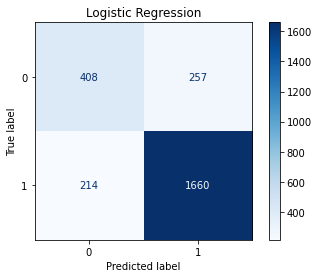




Training Set Accuracy: 0.846
Test Set Accuracy Multinomial Bayes: 0.788
Multinomial Bayes Precision: 0.884
Multinomial Bayes Recall: 0.821
Multinomial Bayes - F1 score: 0.851
Mean Cross-Validation Accuracy: 0.783
Multinomial Bayes
[[ 463  202]
 [ 336 1538]]


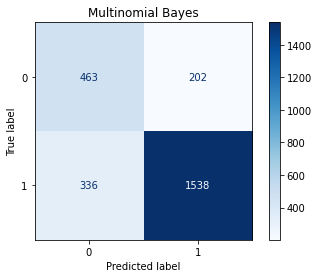




Training Set Accuracy: 1.000
Test Set Accuracy Random Forest: 0.768
Random Forest Precision: 0.767
Random Forest Recall: 0.983
Random Forest - F1 score: 0.862
Mean Cross-Validation Accuracy: 0.772
Random Forest
[[ 107  558]
 [  32 1842]]


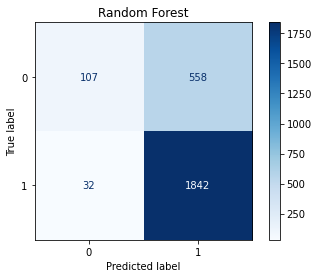




Training Set Accuracy: 0.857
Test Set Accuracy MNB with TFIDF: 0.789
MNB with TFIDF Precision: 0.787
MNB with TFIDF Recall: 0.980
MNB with TFIDF - F1 score: 0.873
Mean Cross-Validation Accuracy: 0.789
MNB with TFIDF
[[ 167  498]
 [  38 1836]]


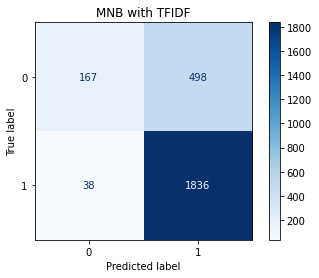




Training Set Accuracy: 0.866
Test Set Accuracy Logistic Regression With TFIDF: 0.819
Logistic Regression With TFIDF Precision: 0.825
Logistic Regression With TFIDF Recall: 0.959
Logistic Regression With TFIDF - F1 score: 0.887
Mean Cross-Validation Accuracy: 0.816
Logistic Regression With TFIDF
[[ 283  382]
 [  77 1797]]


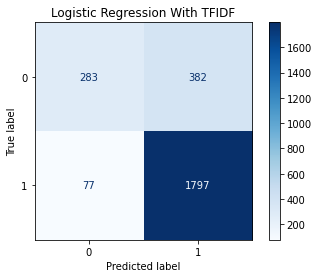

In [27]:
ModelEvaluation('Logistic Regression', logreg, X_train, X_test)
ModelEvaluation('Multinomial Bayes', mnb, X_train, X_test)
ModelEvaluation('Random Forest', rf, X_train, X_test)
ModelEvaluation('MNB with TFIDF', mnb_tfidf, X_train_tfidf, X_test_tfidf)
ModelEvaluation('Logistic Regression With TFIDF', logreg_tfidf, X_train_tfidf, X_test_tfidf)

## The best models are: Logistic Regression with and without the TFIDF vectorization, and MNB with TFIDF

Now, we'll put all of those through GridSearchCV to increase performance

In [37]:
def HyperParamModel(model, params, features, label, cv, test_x):
    grid = GridSearchCV(model(), params, cv=cv, n_jobs=-1)
    grid.fit(features, label)
    print("Best Hyperparameters", grid.best_params_)
    print("Best Parameter Score", grid.best_score_)

    if model == LogisticRegression:
        c = grid.best_params_['C']
        max_iter = grid.best_params_['max_iter']
        testing_model = model(C=c, max_iter=max_iter)
        testing_model.fit(features, label)

    else:
        alpha = grid.best_params_['alpha']
        testing_model = model(alpha=alpha)
        testing_model.fit(features, label)

    pred = testing_model.predict(test_x)
    score = accuracy_score(y_test, pred)
    print("Test Accuracy", score)

In [38]:
param_MNB = {'alpha': [0.01, 0.02, 0.05, 0.1]}
MNB = MultinomialNB

param_logreg = {'C': [0.01, .1, .2, 1], 'max_iter': [10000, 20000, 30000]}
LGR = LogisticRegression

HyperParamModel(LGR, param_logreg, X_train, y_train, 5, X_test)
HyperParamModel(LGR, param_logreg, X_train_tfidf, y_train, 5, X_test_tfidf)
HyperParamModel(MNB, param_MNB, X_train_tfidf, y_train, 5, X_test_tfidf)

Best Hyperparameters {'C': 0.2, 'max_iter': 10000}
Best Parameter Score 0.8212364507765109
Test Accuracy 0.8259157148483655
Best Hyperparameters {'C': 1, 'max_iter': 10000}
Best Parameter Score 0.8159182426090184
Test Accuracy 0.8192201654194565
Best Hyperparameters {'alpha': 0.05}
Best Parameter Score 0.7903088337662779
Test Accuracy 0.7904686884600236


### Logistic Regression without TFIDF wins